In [1]:
#%matplotlib notebook  
from matplotlib import pyplot as plt
import numpy as np
import pasttrec_ctrl as ptc
import json
import sigproc_kit
import tdc_daq as td
import baseline_calib
import ROOT

from my_utils import *
set_width_max_of_jupyterpad()

def fwhm(x,y):
  dummy, t1, tot = sigproc_kit.discriminate(x,y,np.max(y)/2.,0,0)
  return tot

def hist_rms(x,y):
  counts = np.sum(y)
  weights = y / counts
  mean = np.dot(x,weights)
  deviations = x - mean
  return np.sqrt(  np.dot(deviations**2,weights)   )
def list_rms(x):
  mean = sum(x)/len(x)
  deviations = x - mean
  return np.sqrt(  sum(deviations**2) /len(x)  )
def list_mean(x):
  mean = sum(x)/len(x)
  return mean

Welcome to JupyROOT 6.14/04


In [2]:
import db
print(db.board_list())

['0014', '0021', '0018', '0022', '0003', '0008', '0027', '0026', '0025', '0004', '0110', '0111', '0029', '0023', '0030', '0015', '0017', '0010', '0016', '0020', '0006', '0011', '0009', '0007', '0013', '0106', '0002', '0101', '0028', '0104', '0102', '0103', '0108', '0105', '0005']


['0014', '0021', '0018', '0022', '0003', '0008', '0027', '0026', '0025', '0004', '0110', '0111', '0029', '0023', '0030', '0015', '0017', '0010', '0016', '0020', '0006', '0011', '0009', '0007']
0 board = 0014 ------------> peaking time =  15 , gain =  4
1 . scan 
 parallel baseline scan, all channels same baseline set at a step


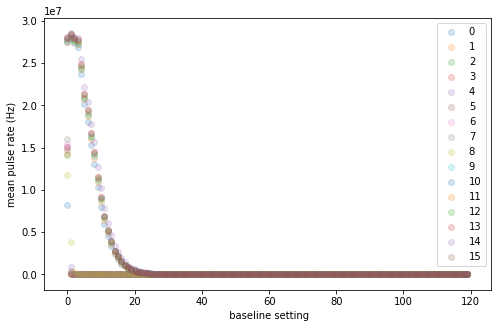

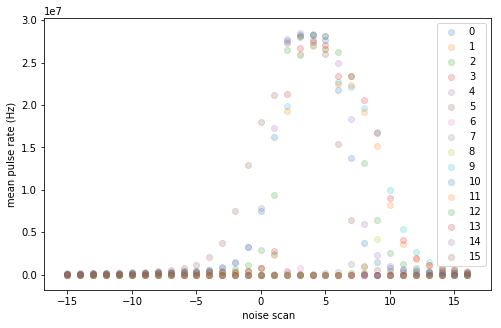

0014 average(16chan) noise thresh: mean =  4.814  +-  2.069   |  RMS  =  1.466  +-  1.309
1 board = 0014 ------------> peaking time =  15 , gain =  4
2 . scan 
 individual baseline scan, inactive = -15 


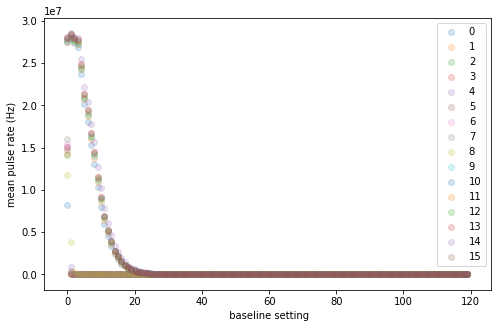

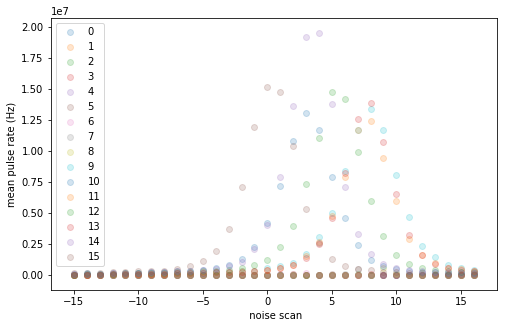

0014 average(16chan) noise thresh: mean =  4.97  +-  2.599   |  RMS  =  1.59  +-  1.517
2 board = 0014 ------------> peaking time =  15 , gain =  4
3 . scan 
 individual baseline scan, all other channesl active  baseline = calibrated individual baseline
[3.0, 2.0, 7.0, 8.0, 2.0, 5.0, 3.0, 7.0, 9.0, 8.0, 3.0, 8.0, 5.0, 8.0, 4.0, 0.0]


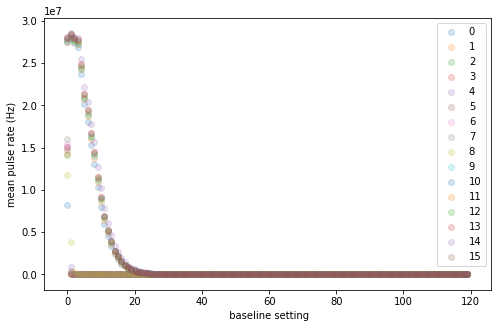

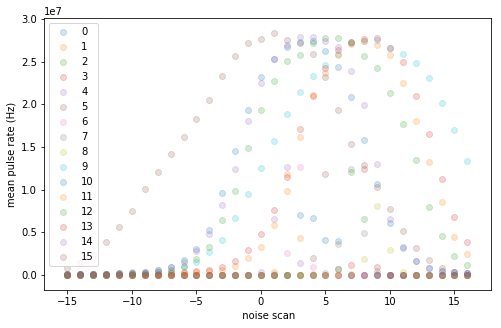

0014 average(16chan) noise thresh: mean =  5.12  +-  2.602   |  RMS  =  2.285  +-  1.961
0 board = 0021 ------------> peaking time =  15 , gain =  4
4 . scan 
 parallel baseline scan, all channels same baseline set at a step


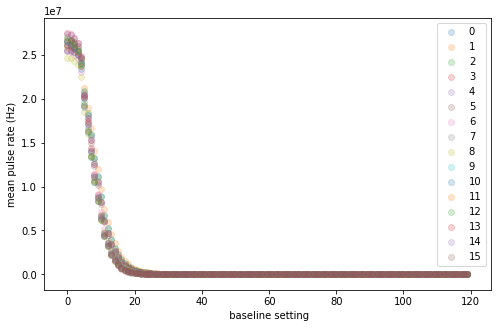

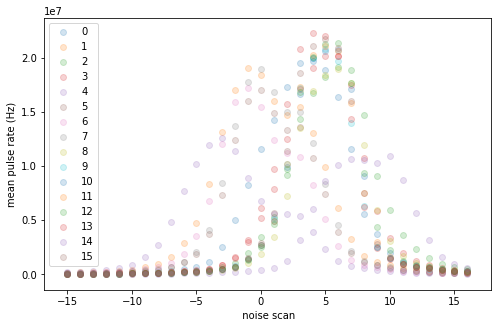

0021 average(16chan) noise thresh: mean =  3.453  +-  2.513   |  RMS  =  3.313  +-  0.365
1 board = 0021 ------------> peaking time =  15 , gain =  4
5 . scan 
 individual baseline scan, inactive = -15 


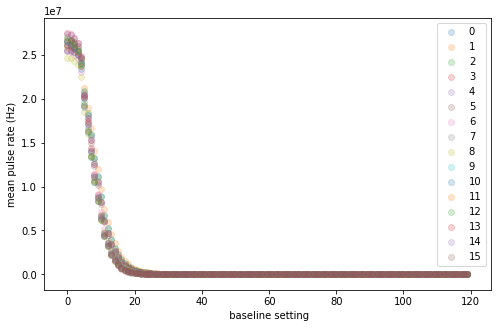

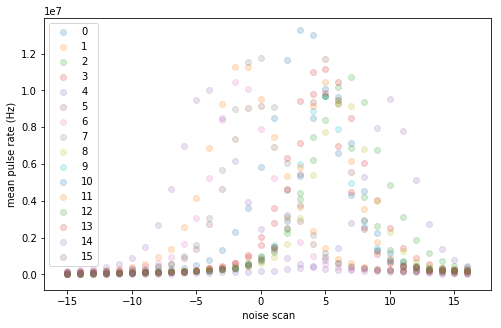

0021 average(16chan) noise thresh: mean =  3.252  +-  3.473   |  RMS  =  3.466  +-  0.232
2 board = 0021 ------------> peaking time =  15 , gain =  4
6 . scan 
 individual baseline scan, all other channesl active  baseline = calibrated individual baseline
[3.0, -1.0, 7.0, 5.0, -4.0, -0.0, -2.0, -0.0, 6.0, 5.0, 5.0, 5.0, 5.0, 4.0, 10.0, 5.0]


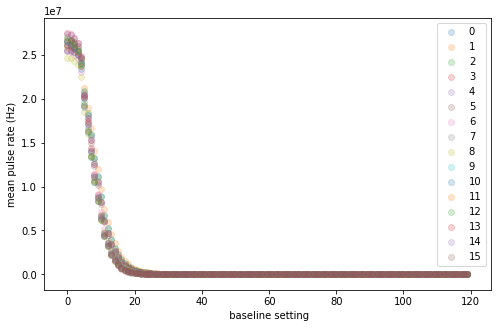

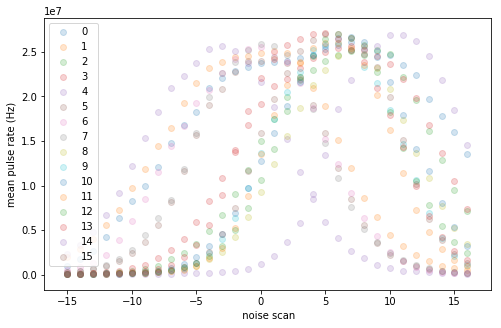

0021 average(16chan) noise thresh: mean =  3.65  +-  3.479   |  RMS  =  4.935  +-  0.799
0 board = 0018 ------------> peaking time =  15 , gain =  4
7 . scan 
 parallel baseline scan, all channels same baseline set at a step


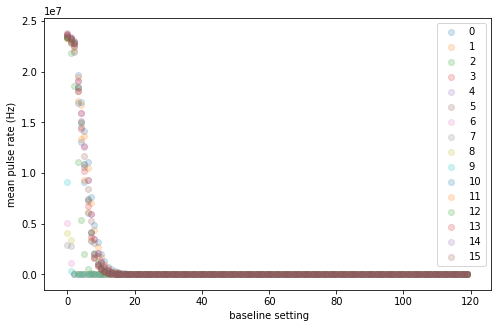

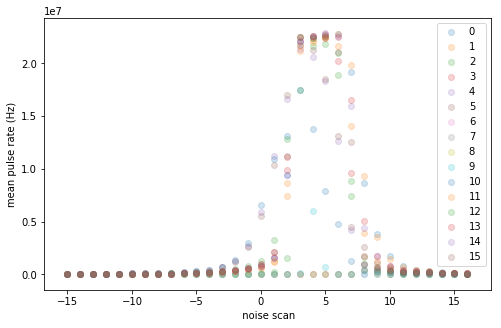

0018 average(16chan) noise thresh: mean =  4.384  +-  2.219   |  RMS  =  1.788  +-  0.833
1 board = 0018 ------------> peaking time =  15 , gain =  4
8 . scan 
 individual baseline scan, inactive = -15 


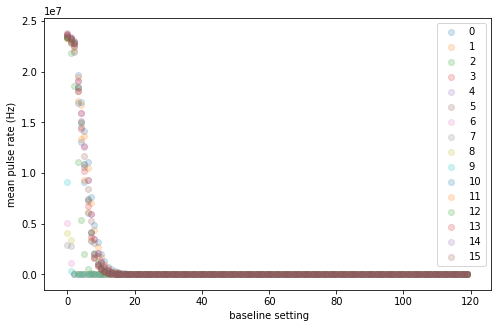

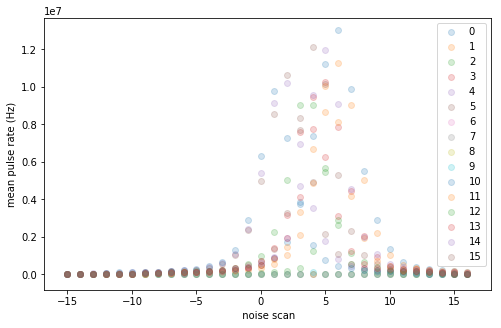

0018 average(16chan) noise thresh: mean =  4.16  +-  2.541   |  RMS  =  2.085  +-  1.079
2 board = 0018 ------------> peaking time =  15 , gain =  4
9 . scan 
 individual baseline scan, all other channesl active  baseline = calibrated individual baseline
[6.0, 6.0, 5.0, 5.0, 2.0, 2.0, -2.0, 9.0, 9.0, 4.0, 1.0, 5.0, 4.0, 4.0, 5.0, 4.0]


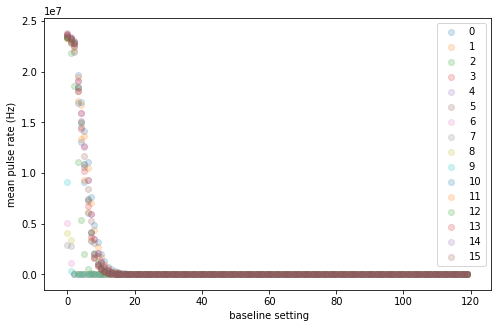

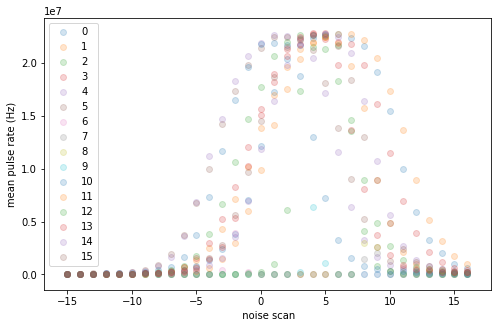

0018 average(16chan) noise thresh: mean =  3.821  +-  2.628   |  RMS  =  2.736  +-  1.415
0 board = 0022 ------------> peaking time =  15 , gain =  4
10 . scan 
 parallel baseline scan, all channels same baseline set at a step


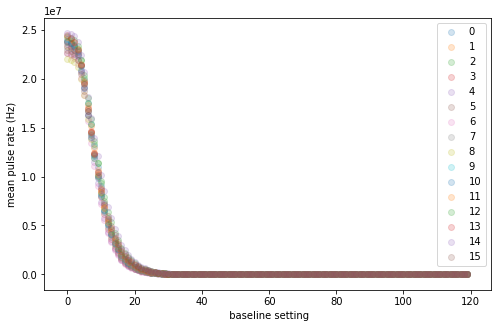

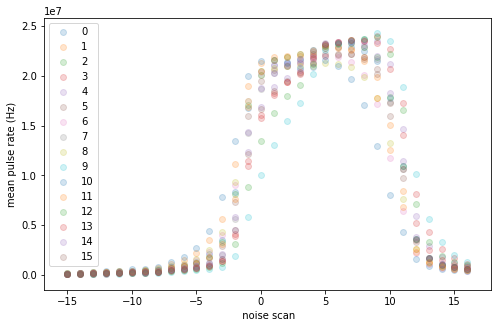

0022 average(16chan) noise thresh: mean =  4.709  +-  0.765   |  RMS  =  4.228  +-  0.097
1 board = 0022 ------------> peaking time =  15 , gain =  4
11 . scan 
 individual baseline scan, inactive = -15 


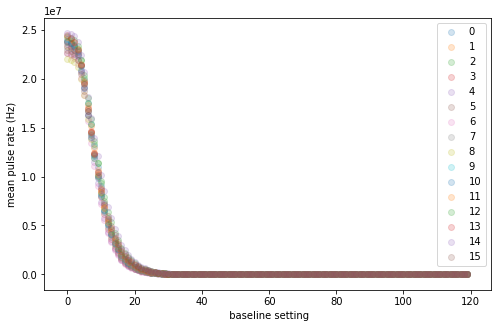

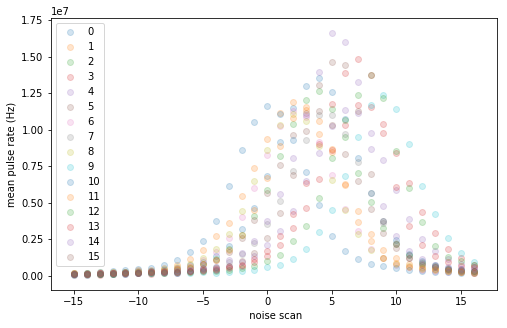

0022 average(16chan) noise thresh: mean =  4.214  +-  2.149   |  RMS  =  4.068  +-  0.139
2 board = 0022 ------------> peaking time =  15 , gain =  4
12 . scan 
 individual baseline scan, all other channesl active  baseline = calibrated individual baseline
[4.0, 2.0, 4.0, 7.0, 6.0, 4.0, 2.0, 5.0, 2.0, 9.0, 0.0, 3.0, 8.0, 6.0, 5.0, 5.0]


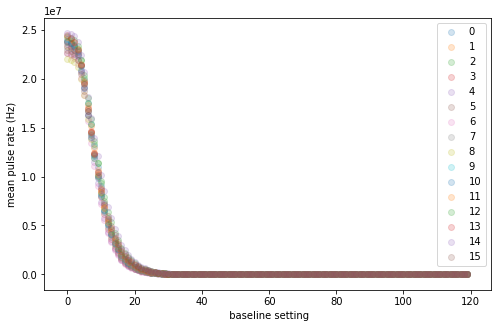

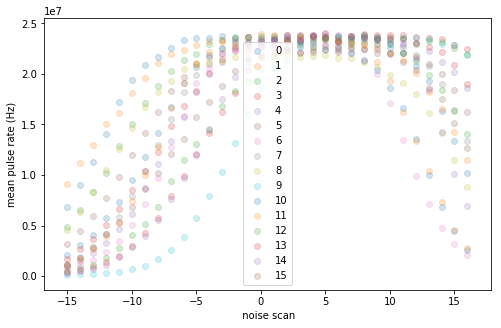

0022 average(16chan) noise thresh: mean =  2.984  +-  1.67   |  RMS  =  7.312  +-  0.639
0 board = 0003 ------------> peaking time =  15 , gain =  4
13 . scan 
 parallel baseline scan, all channels same baseline set at a step


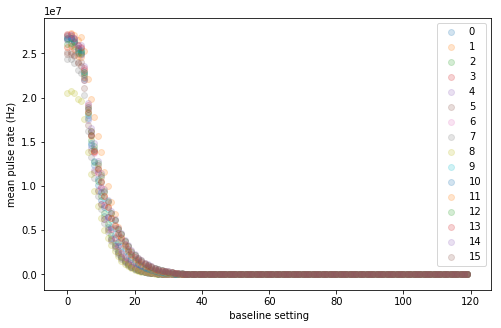

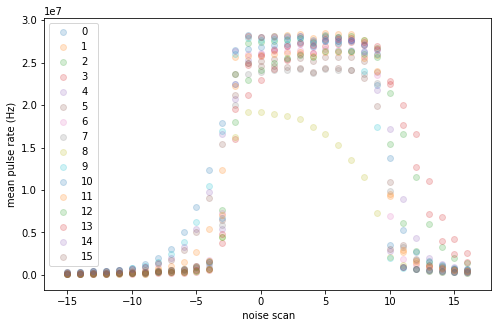

0003 average(16chan) noise thresh: mean =  3.594  +-  0.893   |  RMS  =  4.245  +-  0.22
1 board = 0003 ------------> peaking time =  15 , gain =  4
14 . scan 
 individual baseline scan, inactive = -15 


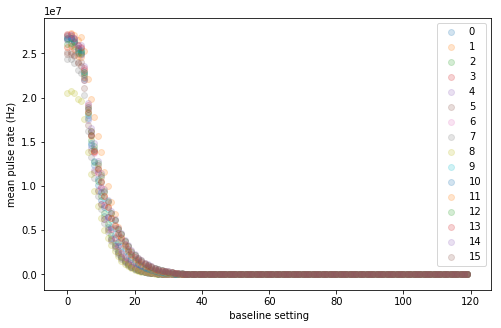

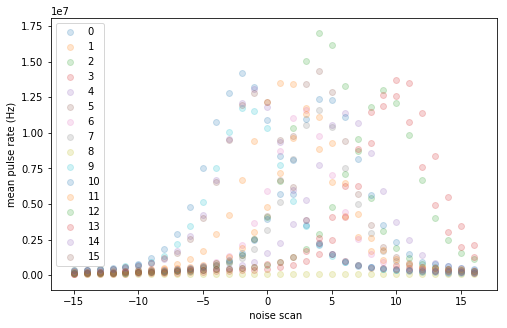

0003 average(16chan) noise thresh: mean =  3.073  +-  3.469   |  RMS  =  4.396  +-  1.224
2 board = 0003 ------------> peaking time =  15 , gain =  4
15 . scan 
 individual baseline scan, all other channesl active  baseline = calibrated individual baseline
[-2.0, 4.0, 4.0, 11.0, 6.0, 4.0, 4.0, 4.0, 4.0, -1.0, 4.0, 4.0, 9.0, 9.0, -1.0, -1.0]


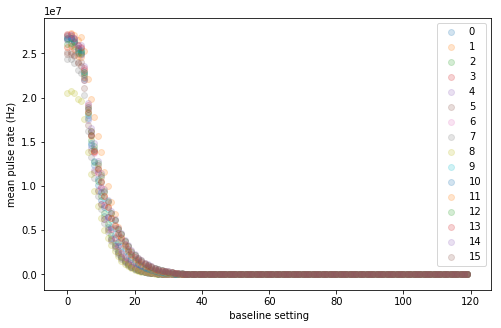

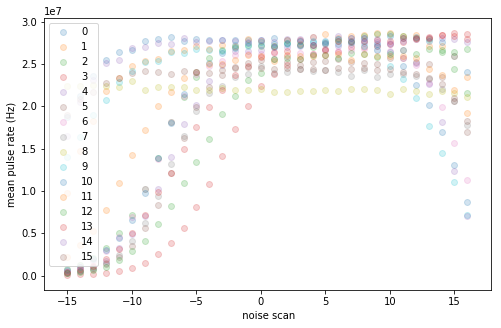

0003 average(16chan) noise thresh: mean =  2.841  +-  2.071   |  RMS  =  7.727  +-  0.849
0 board = 0008 ------------> peaking time =  15 , gain =  4
16 . scan 
 parallel baseline scan, all channels same baseline set at a step


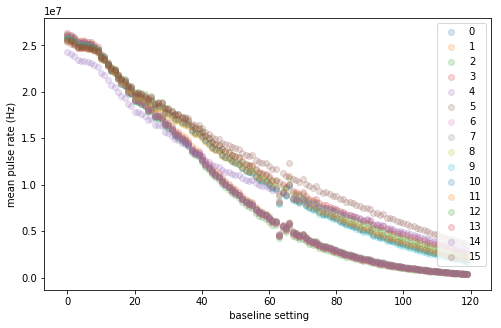

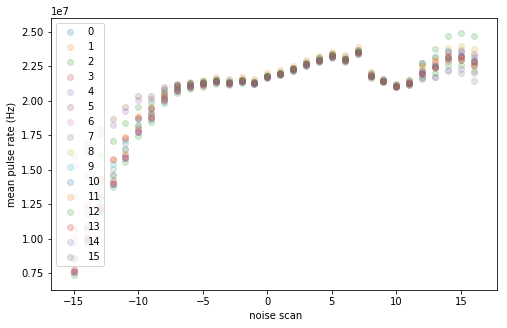

0008 average(16chan) noise thresh: mean =  1.668  +-  0.28   |  RMS  =  8.774  +-  0.115
1 board = 0008 ------------> peaking time =  15 , gain =  4
17 . scan 
 individual baseline scan, inactive = -15 


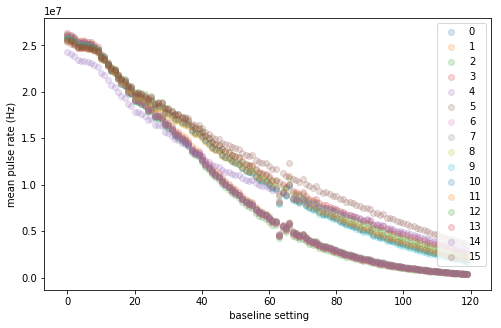

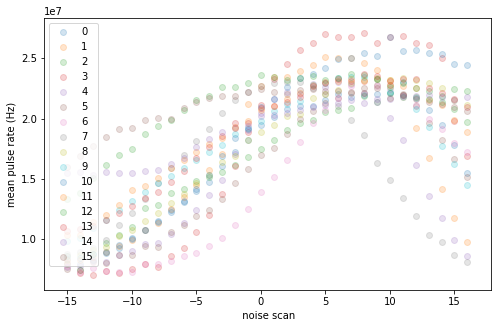

0008 average(16chan) noise thresh: mean =  2.504  +-  0.947   |  RMS  =  8.404  +-  0.366
2 board = 0008 ------------> peaking time =  15 , gain =  4
18 . scan 
 individual baseline scan, all other channesl active  baseline = calibrated individual baseline
[7.0, 5.0, 9.0, 6.0, 5.0, 7.0, 7.0, -0.0, 7.0, 4.0, 7.0, 4.0, -1.0, 4.0, 4.0, -1.0]


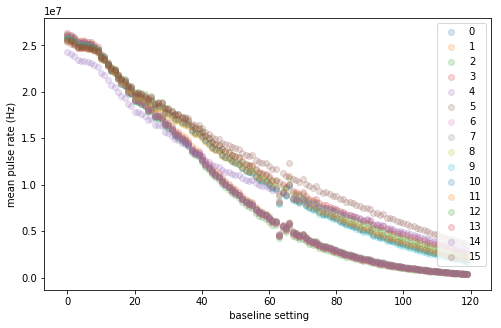

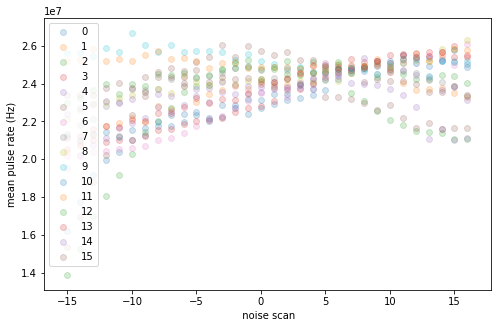

0008 average(16chan) noise thresh: mean =  0.838  +-  0.384   |  RMS  =  9.119  +-  0.117
0 board = 0027 ------------> peaking time =  15 , gain =  4
19 . scan 
 parallel baseline scan, all channels same baseline set at a step


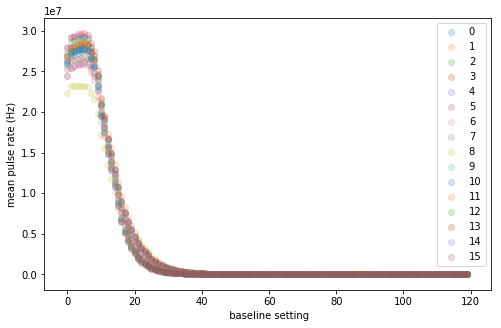

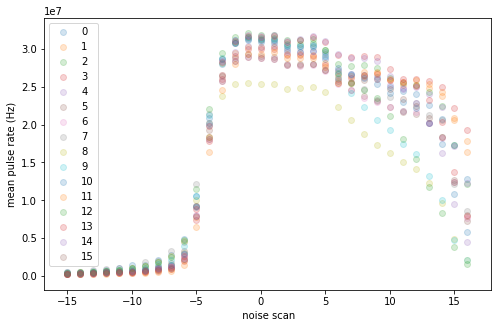

0027 average(16chan) noise thresh: mean =  4.539  +-  0.634   |  RMS  =  5.881  +-  0.196
1 board = 0027 ------------> peaking time =  15 , gain =  4
20 . scan 
 individual baseline scan, inactive = -15 


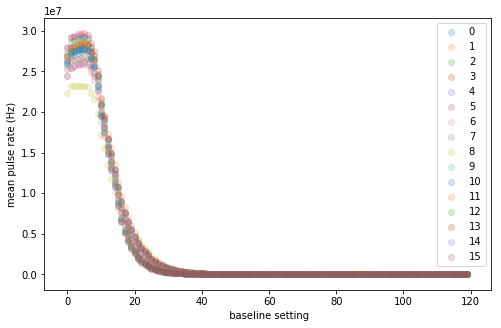

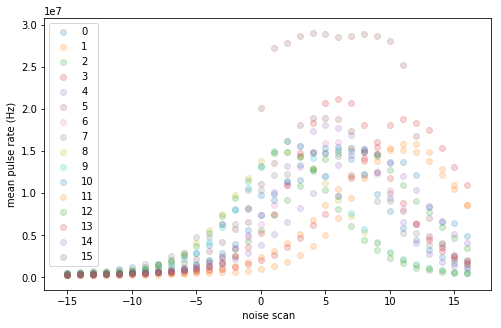

0027 average(16chan) noise thresh: mean =  5.405  +-  2.36   |  RMS  =  5.107  +-  0.413
2 board = 0027 ------------> peaking time =  15 , gain =  4
21 . scan 
 individual baseline scan, all other channesl active  baseline = calibrated individual baseline
[7.0, 11.0, 7.0, 11.0, 8.0, 6.0, 6.0, 5.0, 2.0, 3.0, 5.0, 11.0, 2.0, 7.0, 5.0, 7.0]


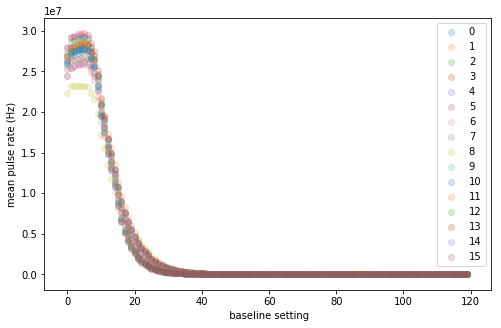

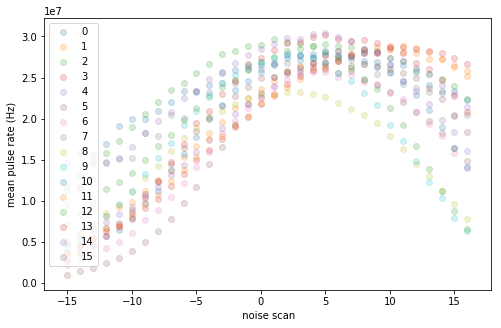

0027 average(16chan) noise thresh: mean =  2.878  +-  1.293   |  RMS  =  7.767  +-  0.452
0 board = 0026 ------------> peaking time =  15 , gain =  4
22 . scan 
 parallel baseline scan, all channels same baseline set at a step


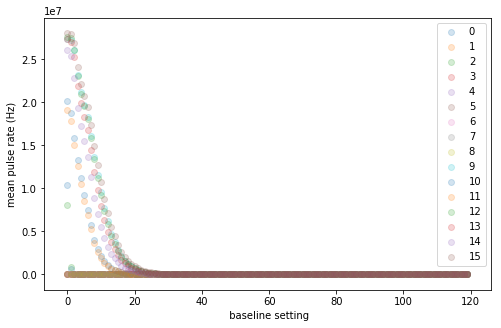

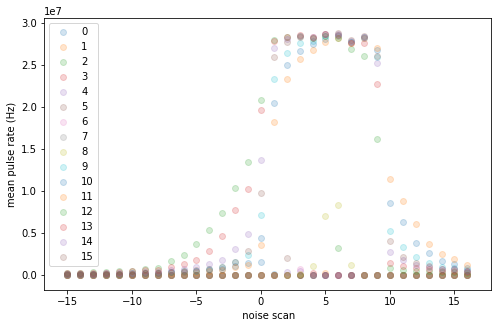

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


0026 average(16chan) noise thresh: mean =  nan  +-  nan   |  RMS  =  nan  +-  nan
1 board = 0026 ------------> peaking time =  15 , gain =  4
23 . scan 
 individual baseline scan, inactive = -15 


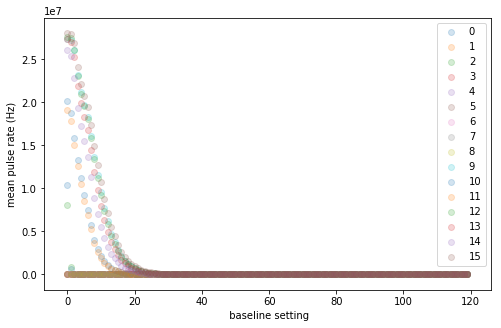

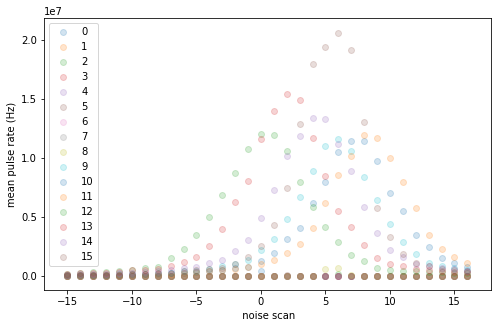

0026 average(16chan) noise thresh: mean =  nan  +-  nan   |  RMS  =  nan  +-  nan
2 board = 0026 ------------> peaking time =  15 , gain =  4
24 . scan 
 individual baseline scan, all other channesl active  baseline = calibrated individual baseline
[0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]


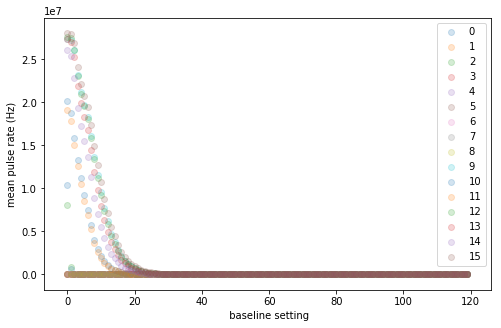

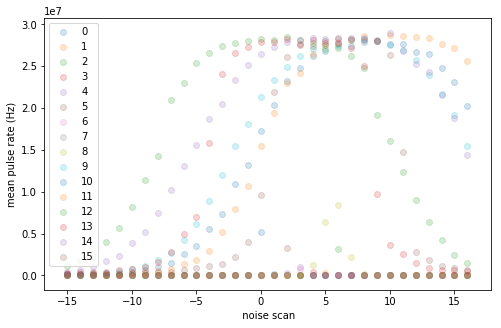

0026 average(16chan) noise thresh: mean =  3.846  +-  2.455   |  RMS  =  2.547  +-  2.645
0 board = 0025 ------------> peaking time =  15 , gain =  4
25 . scan 
 parallel baseline scan, all channels same baseline set at a step


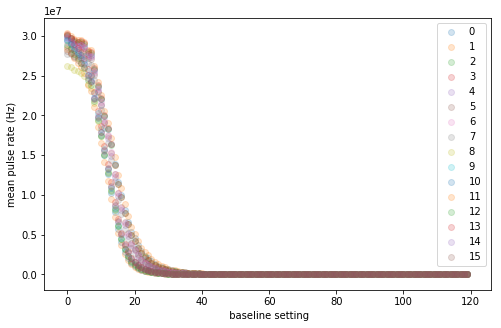

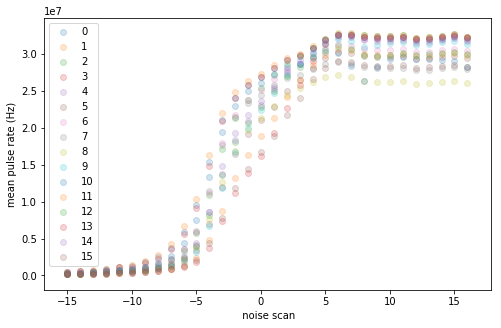

0025 average(16chan) noise thresh: mean =  6.722  +-  0.503   |  RMS  =  5.977  +-  0.274
1 board = 0025 ------------> peaking time =  15 , gain =  4
26 . scan 
 individual baseline scan, inactive = -15 


TrbException: ('Error while writing trb register.', 41, 'TRB3 Invalid UDP Header, check Firmware')

>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reache

In [3]:
# used_boards = ["0111"]
used_boards = db.board_list_installed()
# used_boards = used_boards[0:10]
print(used_boards)
nscans = 3

## scan threshold of all boar
from functools import (reduce)
from math import (sqrt)
import numpy as np
import time
import tdc_daq as td
import matplotlib.pyplot as plt
import db



# rootMeanSquare :: [Num] -> Float
def rootMeanSquare(xs):
    return sqrt(reduce(lambda a, x: a + x * x, xs, 0) / len(xs))
def MeanArrays(xs,ys):
    return np.dot(xs,ys)/sum(ys)

#ptime_list = [ 10, 15, 20 ]
ptime_list = [ 15 ]
# pt_gain_list = [ 1, 2, 4 ]
pt_gain_list = [4]  

# for single board noise measurement, set all other boards to standby
for my_board in db.board_list():
  db.set_standby_board(my_board)



n_scan_steps = len(ptime_list)*len(pt_gain_list)*nscans

plt.rcParams["figure.figsize"] = (8,5)
trendtime_list = []
rmsAverageTrend_list = []
rmsAverageTrendError_list = []
meanAverageTrend_list = []
meanAverageTrendError_list = []

mean_scans = [[[] for b in range(len(used_boards)) ]  for i in range(n_scan_steps) ]
rms_scans =  [[[] for b in range(len(used_boards)) ]  for i in range(n_scan_steps) ]

scaler_list_channel = [[[] for i in range(n_scan_steps) ]  for i in range(16)] 
   




for ptime in ptime_list: 
 for pt_gain in pt_gain_list: 
  b = -1    
  for name in used_boards: 
   b += 1        
   scan_step = -1
   for scan in range(0,nscans): 
    scan_step += 1 
    print(scan_step,"board =" , name, "------------> peaking time = ", ptime, ", gain = ", pt_gain)
    #alert("next measure")
#     input("Press enter to continue")

    db.unset_standby_board(name)
    td.enable_tdc_channels_of_active_boards()
    ptc.init_active_boards()
    # pause for not killing trb by sending to many parallel commands regiser writes:
    time.sleep(5) 
    trendtime_list += [ name ]
    ptc.init_boards_by_name(used_boards, ptime, pt_gain)   
    print(len(trendtime_list),". scan ")
    #### baseline scan, all channels in parallel (same baseline set to all channels at once):
    if scan == 0:
            print(" parallel baseline scan, all channels same baseline set at a step")        
            baseline_calib.baseline_calib_by_noise(name, dummy_calib=True) 
    #### baseline scan each channel individual, while other channels are "inactive", = baseline is minimal -15 or (maximal +15)
    if scan == 1:
           print(" individual baseline scan, inactive = -15 ")
           baseline_calib.baseline_calib_by_noise(name, dummy_calib=True,individual=True) 
    if scan == 2:
       print(" individual baseline scan, all other channesl active  baseline = calibrated individual baseline")
       bl_values = [0]*16
        # get the baselines calibrated for all 16 channels from database:
       calib = db.get_calib_json_by_name(name)
       if ("baselines" in calib):
           board_baselines = calib["baselines"]
           bl_values   = board_baselines[0:17]   
       print(bl_values)
       baseline_calib.baseline_calib_by_noise(name, dummy_calib=True,individual=True,baseline_inactive=bl_values)


    if scan == 3:
         print(" individual baseline scan, all other channesl active  baseline = calibrated individual baseline")
         baselines_set =  [15] * 16
         baseline_calib.set_baselines_individual(name,baselines_set)
         baseline_calib.char_noise_by_thresh_scan(name,dummy_calib=True)

    dummy_calib = db.get_calib_json_by_name(name,dummy_calib=True)

    #print(json.dumps(dummy_calib,indent=2, sort_keys=True))
    #threshold scan:
    tsbl_scan_raw = dummy_calib["tsbl_scan_raw"]
    tsbl_range    = dummy_calib["tsbl_range"]
    # baseline scan:
    noise_scan_raw = dummy_calib["noise_scan_raw"]
    noise_range    = dummy_calib["bl_range"]
   
    for i in range(0,16):
     plt.scatter(tsbl_range,tsbl_scan_raw[i],alpha=0.2,label = "{:d}".format(i))

     plt.legend()
     plt.xlabel("  baseline setting ")
     plt.ylabel("mean pulse rate (Hz)")
     #plt.yscale('log') 
    plt.show()

    for i in range(0,16):
     plt.scatter(noise_range,noise_scan_raw[i],alpha=0.2,label = "{:d}".format(i))

     plt.legend()
     plt.xlabel("  noise scan ")
     plt.ylabel("mean pulse rate (Hz)")
     #plt.yscale('log') 
    plt.show()
    fwhm_list = []
    max_list  = []
    rms_list = []
    mean_list = []
#     for i in range(0,16):
#       fwhm_list += [ fwhm(tsbl_range,tsbl_scan_raw[i]) ]
#       rms_list += [ hist_rms(tsbl_range,tsbl_scan_raw[i]) ]
#       mean_list += [ MeanArrays(tsbl_range,tsbl_scan_raw[i]) ]  
#       max_list  += [ np.max(tsbl_scan_raw[i])  ]
#       scaler_list_channel[i][scan_step] = tsbl_scan_raw[i]     
    for i in range(0,16):
      fwhm_list += [ fwhm(noise_range,noise_scan_raw[i]) ]
      rms_list += [ hist_rms(noise_range,noise_scan_raw[i]) ]
      mean_list += [ MeanArrays(noise_range,noise_scan_raw[i])  ]  
      max_list  += [ np.max(noise_scan_raw[i])  ]
      scaler_list_channel[i][scan_step] = noise_scan_raw[i] 
    
    mean_scans[scan][b] = mean_list
    rms_scans[scan][b]  = rms_list    
    fwhm_list = np.array(fwhm_list)
    max_list  = np.array(max_list)
    
    print(name, "average(16chan) noise thresh: mean = ", round(sum(mean_list)/len(mean_list),3), " +- ", round(list_rms(mean_list),3), "  |  RMS  = ", round(sum(rms_list)/len(rms_list),3), " +- ", round(list_rms(rms_list),3) )

    meanAverageTrend_list += [ sum(mean_list)/len(mean_list) ]
    meanAverageTrendError_list += [ list_rms(mean_list) ]
    rmsAverageTrend_list += [ sum(rms_list)/len(rms_list) ]
    rmsAverageTrendError_list += [ list_rms(rms_list) ]    
    



In [ ]:
for i in range(len(used_boards)):
 print(used_boards[i])
 for scan in range(0,nscans): 
    plt.scatter(list(range(0,len(mean_scans[scan][i]))), mean_scans[scan][i],label = "scan {:d}".format(scan))
    plt.xlabel("channel no")
    plt.ylabel("mean")
#     plt.ylim(ymax = 8, ymin = 0)
 plt.legend()
 plt.show()
for i in range(len(used_boards)):
 print(used_boards[i])
 for scan in range(0,nscans): 
#     plt.scatter(list(range(0,len(mean_scans[scan]))),rms_scans[scan],color='blue',label = "scan {:d}".format(scan))
    plt.scatter(list(range(0,len(mean_scans[scan][i]))),rms_scans[scan][i], label = "scan {:d}".format(scan))  
    plt.xlabel("channel no")
    plt.ylabel("RMS")
#     plt.ylim(ymax = 6, ymin = 0)
    plt.title("noise width (RMS)")
 plt.legend()
 plt.show()

for ch in range(0,16):
    print("channel : ",ch)
    for i in range(0,len(scaler_list_channel[ch])):
     plt.scatter(noise_range,scaler_list_channel[ch][i],label = "{:d}".format(i))

     plt.legend()
     plt.xlabel("threshold (at maximum baseline setting)")
     plt.ylabel("mean pulse rate (Hz)")
     #plt.yscale('log') 
    plt.show()


In [ ]:
#archive(label="baseline_individual_scan_board0021_4xLVDS-Ferrites")

In [ ]:
plt.errorbar(trendtime_list, meanAverageTrend_list, yerr=meanAverageTrendError_list, fmt='o')
#plt.scatter(trendtime_list, meanAverageTrend_list)
plt.xlabel("board")
plt.ylabel("Mean average of 16 channels")
plt.title("mean")
plt.show()
    
plt.errorbar(trendtime_list, rmsAverageTrend_list, yerr=rmsAverageTrendError_list, fmt='o')
plt.xlabel("board")
plt.ylabel("RMS threshold [DAQ] average of 16 channels")
plt.title("RMS")
plt.legend()
plt.show()

import ROOT


gr  = ROOT.TGraphErrors()
gr2 = ROOT.TGraphErrors()
#len(meanAverageTrend_list),np.array(trendtime_list),np.array(meanAverageTrend_list))
for i in range(0,len(meanAverageTrend_list)):
    gr.SetPoint(i, np.double(trendtime_list[i]), np.double(meanAverageTrend_list[i]))
    gr.SetPointError(i, 0, np.double(meanAverageTrendError_list[i]) )
    gr2.SetPoint(i, np.double(trendtime_list[i]), np.double(rmsAverageTrend_list[i]))
    gr2.SetPointError(i, 0, np.double(rmsAverageTrendError_list[i]) )    
c = ROOT.TCanvas("mean","mean",640,480)
gr.Draw("A*")
c.Draw()
c2 = ROOT.TCanvas("rms","rms",640,480)
gr2.Draw("A*")

c2.Draw()
print("Mean (of all boards) = ", list_mean(meanAverageTrend_list), " +- ", list_rms(meanAverageTrend_list) )
print("RMS (of all boards) = ", list_mean(rmsAverageTrend_list), " +- ", list_rms(rmsAverageTrend_list) )

#db.find_board_by_name("0030")

In [ ]:
plt.rcParams["figure.figsize"] = (8,15)
for ch in range(0,16):
    print("channel : ",ch)
    for i in range(0,len(scaler_list_channel[ch])):
     nums = np.array(scaler_list_channel[ch][i])*10**(16-ch)
     plt.scatter(tsbl_range,nums,alpha=0.2,label = "scan {:d}".format(i))

     #plt.legend()
     plt.xlabel("threshold (at maximum baseline setting)")
     plt.ylabel("mean pulse rate (Hz)")

plt.yscale('log') 
plt.ylim(ymax = 1E24, ymin = 1E1)
plt.show()

